In [1]:
import os, sys
import time
import datetime
import pytz
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt 
import random


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Ellipse, Circle

ROOTDIR = os.path.abspath(os.path.realpath('./')) + '/Py'

sys.path.append(os.path.join(ROOTDIR, ''))

import dgckernel

import numpy as np
import scipy.optimize as opt

import collections

from collections import deque


In [66]:
class Graph:
    
    def __init__(self,capacity,cost):
        
        '''capacity matrix'''
        self.capacity = capacity  
        
        '''cost matrix'''
        self.cost = cost
        
        '''flow matrix'''
        
        self.flow=np.zeros(np.shape(self.capacity))

        '''Node'''
        self.node = list(range(len(capacity)))
        
        '''Node size'''
        self.scale = len(self.node)
        
    '''Shortest Path(Minimum-cost) Algorithm'''
    
    def SPFA(self,source,sink):
        
        '''Create array cost_array to store shortest distance'''
        self.cost_array = [float('inf')]*self.scale
        self.cost_array[source]=0
        
        '''Boolean array to check if vertex in the shortest path'''
        self.inQueue = [False]*self.scale
        
        '''Queue'''
        self.queue = deque()
        self.queue.append(source)
        self.inQueue[source] = True
        
        '''Parent visiting Edge'''
        
        self.Parent=[0] * (self.scale)
        
        '''Visited Matrix'''
        
        self.visited = [False] * (self.scale)
        
        self.visited[source]= True
    
        
        while self.queue:
            
            '''Take the front vertex from Queue '''
            u=self.queue.popleft() 
            self.inQueue[u] = False
            
            '''Relaxing all the adjacent edges of vertex taken from the Queue '''
            for v in self.node:
                
                if self.cost[u][v]!=float('inf'):
                    
                    weight=self.cost[u][v]
                    
                    if self.cost_array[v] > self.cost_array[u] + weight and self.flow[u][v]<self.capacity[u][v]:
                        
                        self.cost_array[v]=self.cost_array[u] + weight
                        
                        self.Parent[v]=u
                        
                        self.visited[v]=True
                        
                        '''Check if vertex v is in Queue or not'''
                        if (self.inQueue[v] == False):
                            self.queue.append(v)
                            self.inQueue[v] = True
                            
        return self.visited[sink]
    
    def MCMF(self,source,sink):
        
        '''Initial flow and cost'''
        
        max_flow = 0
        
        min_cost=0
        
        while self.SPFA(source,sink):
            
            current_flow=float('inf')
            
            '''Caculating the current flow'''
            
            current_node=sink
            
            while current_node!=source:
                
                pre_node=self.Parent[current_node]
                
                gap=self.capacity[pre_node][current_node]-self.flow[pre_node][current_node]
                
                current_flow=min(current_flow,gap)
                
                current_node=pre_node
                
            max_flow+=current_flow
            
            '''Updating residual capacities of the edges and reverse edges'''
            
            current_node=sink
            
            while current_node!=source:
                
                pre_node=self.Parent[current_node]
                
                self.flow[pre_node][current_node] += current_flow
                
                self.flow[current_node][pre_node] -= current_flow
                
                current_node=pre_node
                
            min_cost+=self.cost_array[sink]*current_flow
            
        return self.flow

class Stamp_transition(object):
    
    def __init__(self, **kwargs):
        """ Load your trained model and initialize the parameters """
        pass
    
    def Get_date(self,stamp):
        dateArray = datetime.datetime.fromtimestamp(stamp)
        otherStyleTime = dateArray.strftime("%Y-%m-%d %H:%M:%S")
        return otherStyleTime[:10]
    
    '''Time stamp'''
    def Get_stamp(self,time_str):
        timeArray = time.strptime(time_str, "%Y-%m-%d %H:%M:%S")
        timeStamp = int(time.mktime(timeArray))
        return timeStamp
    
    '''Time step'''
    def Get_step(self,stamp,date_str,step):
        baseline = date_str+" 00:00:00";
        baseline = int(self.Get_stamp(baseline))
        current_step=int((stamp-baseline)/step)
        return current_step
    
    def Get_datelist(self, beginDate, endDate):
        date_list=[datetime.datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
        return date_list
    
    def Get_weekday(self,date_str):
        date_str = date_str+" 00:00:00";
        date_str = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return date_str.tm_wday+1

    def Get_normalization(self,end_step,t_step):
        if t_step>=end_step:
            return t_step-end_step
        else:
            return t_step


class Spatial_calculation(object):
    
    def __init__(self, Zoom):
        """ Load your trained model and initialize the parameters """
        self.Zoom=Zoom
        self.CALCULATOR = dgckernel.Calculator()
        self.CALCULATOR.SetLayer(Zoom)
        
    '''GRID ID'''

    def get_grid(self,lng,lat):

        return self.CALCULATOR.HexCellKey(dgckernel.GeoCoord(lat, lng))

    '''GRID SHAPE'''

    def get_grid_shape(self,grid):

        return self.CALCULATOR.HexCellVertexesAndCenter(grid)
        
    '''Neighbor Grid'''

    def grid_neighbor(self, grid, low_layer, up_layer):

        neighbors = self.CALCULATOR.HexCellNeighbor(grid, up_layer)
        _neighbors = self.CALCULATOR.HexCellNeighbor(grid, low_layer)
        neighbors = [e for e in neighbors if e not in _neighbors]
        return neighbors 


def flatten(seq):
    s=str(seq).replace('[', '').replace(']', '') 
    s=[eval(x) for x in s.split(',') if x.strip()]
    return list(set(s))



def MCMF_reposition(Driver_list,Destination_list,Action,Cost_dic,Capacity_dic):

    Driver_dic={}

    for i in range(1,1+len(Driver_list),1):

        j=i-1

        Driver_dic[Driver_list[j]]=i

    Destination_dic={}

    for i in range(1+len(Driver_list),1+len(Driver_list)+len(Destination_list),1):

        j=i-len(Driver_list)-1

        Destination_dic[Destination_list[j]]=i

    '''Reverse'''

    Destination_Reverse={}

    for grid,grid_idx in Destination_dic.items():

        Destination_Reverse[grid_idx]=grid


    Node_size=2+len(Driver_list)+len(Destination_list)

    cost=np.ones([Node_size,Node_size])*float('inf')

    for i in range(Node_size):
        cost[i][i]=0.0


    capacity=np.zeros([Node_size,Node_size])


    for driver,driver_idx in Driver_dic.items():

        capacity[0][driver_idx]=1

        cost[0][driver_idx]=1

        for grid in Action[driver]:

            grid_idx=Destination_dic[grid]

            capacity[driver_idx][grid_idx]=1

            cost[driver_idx][grid_idx]=Cost_dic[grid]

            capacity[grid_idx][-1]=1

            cost[grid_idx][-1]=0

    source=0;sink=Node_size-1

    G=Graph(capacity,cost)

    flow=G.MCMF(source,sink)

    reposition_action={}

    for driver,driver_idx in Driver_dic.items():

        if 1.0 in flow[driver_idx]:

            driver_idx=np.argwhere(flow[driver_idx]==1.0)[0][0]

            reposition_action[driver]=Destination_Reverse[driver_idx]

    return reposition_action 

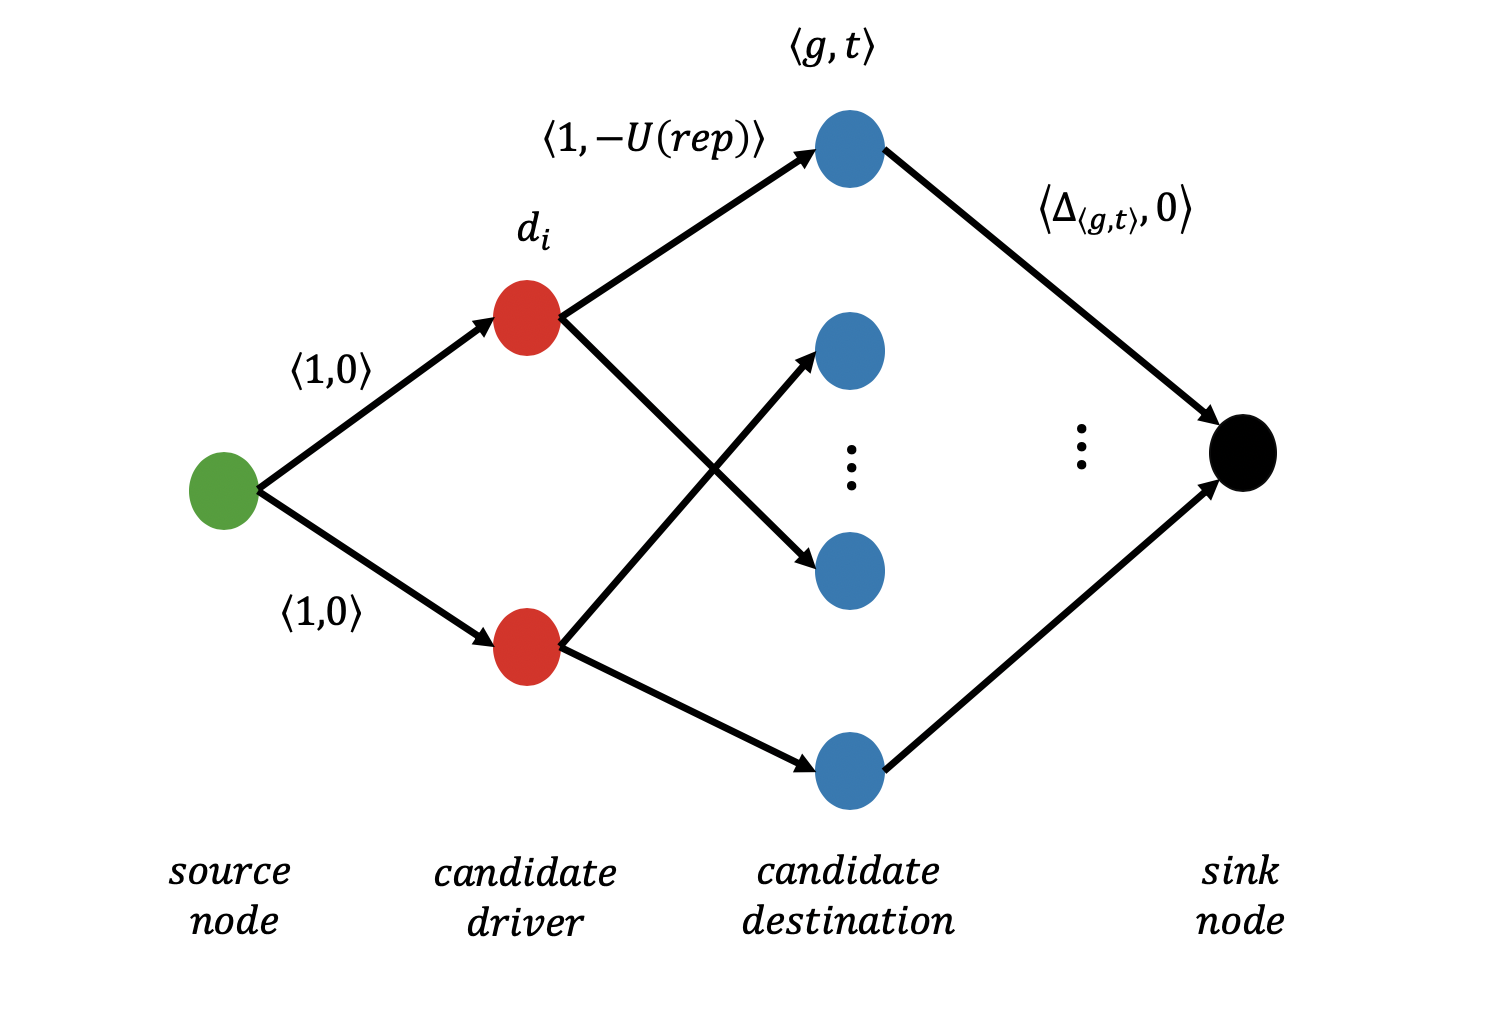

In [67]:
repo_observ={'timestamp': 1479506652,
 'day_of_week': 6,
 'driver_info': [{'driver_id': 0, 'grid_id': '585590200c298702'},
  {'driver_id': 2, 'grid_id': 'ca8819e2fa9adca5'},
  {'driver_id': 6, 'grid_id': '3aaf0fd1566a8890'},
  {'driver_id': 9, 'grid_id': '55225478e97a23f7'},
  {'driver_id': 11, 'grid_id': 'd676136ce01c5942'}]}

MODEL_PATH='Dataset/Order_data/'

In [68]:
Feature_table=pd.read_csv(os.path.join(MODEL_PATH, 'Feature_weekend.csv'))

Feature_table=Feature_table.drop(columns=['Unnamed: 0'])

Grid_info=pd.read_csv(os.path.join(MODEL_PATH, 'Grid_info.csv'))

Grid_info=Grid_info.drop(columns=['Unnamed: 0'])

Reward_dic={}

Capacity_dic={}

for idx,row in Feature_table.iterrows():
    Reward_dic[row['State']]=row['Reward_unit']
    Capacity_dic[row['State']]=row['Order_Cnt']
    
Grid_dic={}

for idx,row in Grid_info.iterrows():

    Grid_dic[row['Grid_id']]=row['grid']

    Grid_dic[row['grid']]=row['Grid_id']

In [69]:
'''Importing Class'''

spatial_calculation=Spatial_calculation(13)

stamp_transition=Stamp_transition()

'''Current Time'''

current_stamp=repo_observ['timestamp']

current_date=stamp_transition.Get_date(current_stamp)

t_step=stamp_transition.Get_step(current_stamp,current_date,600)



In [73]:
Action={}

for driver in repo_observ['driver_info']:

    grid=Grid_dic[driver['grid_id']]

    state=grid+'-'+str(t_step)

    Action_list=list()

    Action_candidate=['0'+'-'+grid]+['1'+'-'+g for g in spatial_calculation.grid_neighbor(grid, 0, 1)]+\
    ['2'+'-'+g for g in spatial_calculation.grid_neighbor(grid, 1, 2)]+\
    ['3'+'-'+g for g in spatial_calculation.grid_neighbor(grid, 2, 3)]+\
    ['4'+'-'+g for g in spatial_calculation.grid_neighbor(grid, 3, 4)]


    Action_=list()

    for a in Action_candidate:

        dest_step=t_step+int(a.split('-')[0])

        dest_step=stamp_transition.Get_normalization(144,dest_step)

        dest_state=a.split('-')[1]+'-'+str(dest_step) 

        Action_.append(dest_state)

    Action_weight={}

    for i in range(len(Action_)):

        if Action_[i] in Reward_dic.keys():

            Action_weight[i]=Reward_dic[Action_[i]]

    layer=5

    while len(Action_weight)==0:

        Action_candidate=[str(layer)+'-'+g for g in spatial_calculation.grid_neighbor(grid, layer-1, layer)]

        Action_=list()

        for a in Action_candidate:

            dest_step=t_step+int(a.split('-')[0])

            dest_step=stamp_transition.Get_normalization(144,dest_step)

            dest_state=a.split('-')[1]+'-'+str(dest_step) 

            Action_.append(dest_state)

        for i in range(len(Action_)):

            if Action_[i] in Reward_dic.keys():

                Action_weight[i]=Reward_dic[Action_[i]]

        if layer>7:

            Action_weight[0]=1.0

            break

        layer+=1

    shortlist=sorted(Action_weight.items(),key=lambda item:item[1],reverse=True)[0:5]

    Action_list=[Action_candidate[idx[0]] for idx in shortlist]

    Action[driver['driver_id']]=Action_list
    
Action

{0: ['8-OL13F1i6661j1594'],
 2: ['8-OL13F1i6676j1595'],
 6: ['8-OL13F1i6570j1638'],
 9: ['8-OL13F1i6674j1595'],
 11: ['8-OL13F1i6623j1610']}

In [75]:
Driver_list=list(Action.keys())

Destination_list=flatten(list(Action.values()))

Cost_={}

Capacity_={}

for dest in Destination_list:

    travel=int(dest.split('-')[0])

    dest_step=t_step+travel

    dest_step=stamp_transition.Get_normalization(144,dest_step)

    dest_grid=dest.split('-')[1]

    dest_state=dest_grid+'-'+str(next_step)

    if dest_state in Reward_dic.keys():

        Cost_[dest]=-1*Reward_dic[dest_state]

        Capacity_[dest]=Capacity_dic[dest_state]

    else:

        Cost_[dest]=0

        Capacity_[dest]=1


Reposition_action=MCMF_reposition(Driver_list,Destination_list,Action,Cost_,Capacity_)

Reposition_action={driver:dest.split('-')[1] for driver,dest in Reposition_action.items()}

repo_action = []

for driver in repo_observ['driver_info']:

    if driver['driver_id'] in Reposition_action.keys():

        dest=Reposition_action[driver['driver_id']]

        if dest in Grid_dic.keys():

            repo_action.append({'driver_id': driver['driver_id'], 'destination': Grid_dic[dest]})

        else:

            repo_action.append({'driver_id': driver['driver_id'], 'destination': driver['grid_id']})

    else:

        repo_action.append({'driver_id': driver['driver_id'], 'destination': driver['grid_id']})
        
repo_action

[{'driver_id': 0, 'destination': 'f0a84b1eed1334eb'},
 {'driver_id': 2, 'destination': 'ca8819e2fa9adca5'},
 {'driver_id': 6, 'destination': '3aaf0fd1566a8890'},
 {'driver_id': 9, 'destination': 'd8def1571f179090'},
 {'driver_id': 11, 'destination': 'd735211ebed3bcb3'}]

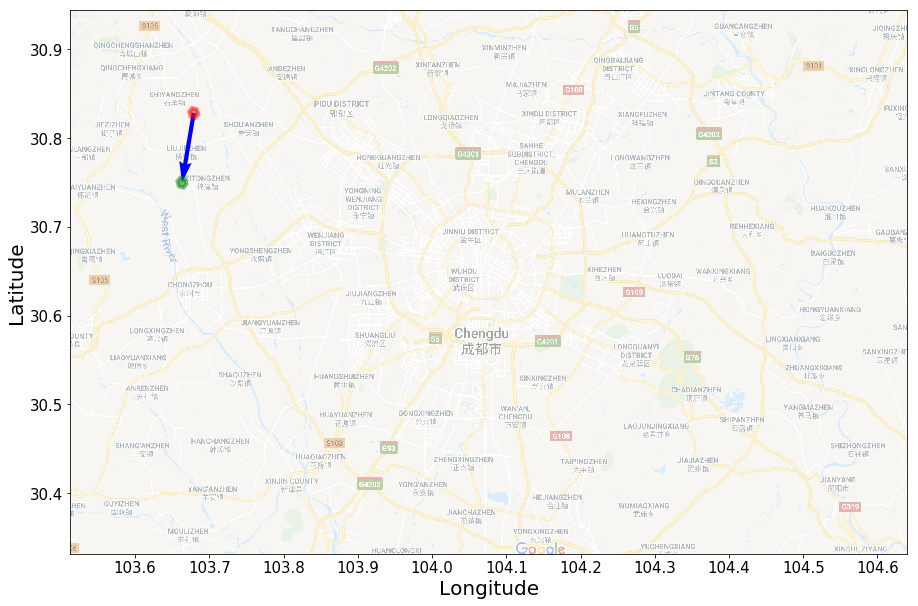

In [76]:

'''Overall range'''
southwest=[30.331759, 103.512892]
northeast=[30.944065, 104.640393]


def draw_bkg(sw,ne):
    
    '''Initial parameter'''
    bg_path='Chengdu.png'
    
    '''Figure out'''
    img = plt.imread(bg_path)
    height, width = img.shape[:2]
    h1 = math.ceil(15./width*height)
    fig = plt.figure(figsize=(15,h1))
    ax = fig.add_subplot(111)
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    plt.xlim(xgrange)
    plt.ylim(ygrange)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    plt.xticks(np.arange(xgrange[0], xgrange[1], 0.352/15))
    plt.yticks(np.arange(ygrange[0], ygrange[1], 0.2415/13))
    try:
        ax.imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)
    except:
        pass
    return fig, ax, xgrange, ygrange

'''2 绘制网络连通性'''

fig, ax, xgrange, ygrange=draw_bkg(southwest,northeast)

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 15}
font_title = {'family' : 'Times New Roman','weight' : 'normal','size': 30}

reposition_task=list(Reposition_action.items())

driver_origin=[(driver['driver_id'],Grid_dic[driver['grid_id']]) for driver in repo_observ['driver_info']]

    
for i in range(len(driver_origin)):
    
    origin=driver_origin[i][1]
    destination=reposition_task[i][1]
    
    vv_f,cc_f=spatial_calculation.get_grid_shape(origin)
    v_f,c_f=spatial_calculation.get_grid_shape(destination)
    
    pgon = plt.Polygon(([v_f[0].lng,v_f[0].lat], [v_f[1].lng,v_f[1].lat], [v_f[2].lng,v_f[2].lat]\
                            ,[v_f[3].lng,v_f[3].lat],[v_f[4].lng,v_f[4].lat],[v_f[5].lng,v_f[5].lat]),color='g',linewidth=4,fill=True,alpha=0.5)
    
    plt.gca().add_patch(pgon)
    
    pgon = plt.Polygon(([vv_f[0].lng,vv_f[0].lat], [vv_f[1].lng,vv_f[1].lat], [vv_f[2].lng,vv_f[2].lat]\
                            ,[vv_f[3].lng,vv_f[3].lat],[vv_f[4].lng,vv_f[4].lat],[vv_f[5].lng,vv_f[5].lat]),color='r',linewidth=4,fill=True,alpha=0.5)

    plt.gca().add_patch(pgon)
    
    

    X_1 =round(cc_f.lng,5)
    Y_1 =round(cc_f.lat,5)
    X_2 =round(c_f.lng,5)
    Y_2=round(c_f.lat,5)
    
    U = round(X_2-X_1,5)
    V = round(Y_2-Y_1,5)


        
    if origin==destination:
        
        cir=Circle(xy = (X_1,Y_1), radius=0.003, alpha=1,color = 'red',linewidth=4, fill = False)

        ax.add_patch(cir)
        
    else:

        plt.quiver(X_1,Y_1,U,V, angles='xy', scale_units='xy', scale=1,color='b',width=.005,headwidth=3,alpha=1,linestyle='--')
        



'''设置坐标轴刻度'''

xmajorLocator   = MultipleLocator(0.1)
ymajorLocator   = MultipleLocator(0.1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)


plt.tick_params(labelsize=15)
font2 = {'weight': 'normal','size': 20}
plt.xlabel('Longitude', font2)
plt.ylabel('Latitude', font2)
plt.xlim((southwest[1], northeast[1]))
plt.ylim((southwest[0], northeast[0]))

plt.show()